In [58]:
import pandas as pd
from dowhy import CausalModel
import dowhy.datasets

import logging
# logging.getLogger("dowhy").setLevel(logging.WARNING)
import warnings
from sklearn.exceptions import DataDimensionalityWarning

warnings.filterwarnings(action="ignore", category=DataDimensionalityWarning)

from IPython.display import display

In [59]:
# Load some sample data
data = dowhy.datasets.linear_dataset(
    beta = 10, # 真の値
    num_common_causes = 5, 
    num_instruments = 2,
    num_samples = 10000,
    treatment_is_binary = True
)

In [60]:
# dataの中に何があるか確認
print(data.keys())
display(data["df"].head())
print("common_causes_names: ",data["common_causes_names"])
print("treatment_name : ",data["treatment_name"])
print("outcome_name : ",data["outcome_name"])
print("instrument_names : ",data["instrument_names"])
print(data["ate"])

dict_keys(['df', 'treatment_name', 'outcome_name', 'common_causes_names', 'instrument_names', 'effect_modifier_names', 'frontdoor_variables_names', 'dot_graph', 'gml_graph', 'ate'])


,Z0,Z1,W0,W1,W2,W3,W4,v0,y
0,0.0,0.923559,0.743725,1.962078,0.072933,-0.143624,-1.286221,True,13.265906
1,0.0,0.257657,1.461817,-0.362384,0.673226,-0.017687,2.319520,True,21.939324
2,0.0,0.192281,-0.756089,1.559235,-0.731728,-1.839954,1.168699,True,11.579270
3,1.0,0.784207,2.764126,1.223004,0.418905,0.653344,-0.210166,True,22.989194
4,0.0,0.333076,0.261801,0.637699,-2.470383,0.484766,0.957123,True,18.430205


common_causes_names:  ['W0', 'W1', 'W2', 'W3', 'W4']
treatment_name :  ['v0']
outcome_name :  y
instrument_names :  ['Z0', 'Z1']
9.999974346669697


In [61]:
# Ⅰ. Create a causal model from data and domain knowledge
model = CausalModel(
    data = data["df"],
    treatment = data["treatment_name"], 
    outcome = data["outcome_name"], 
    common_causes=data["common_causes_names"], 
    instrumental_variables = data["instrument_names"]
)

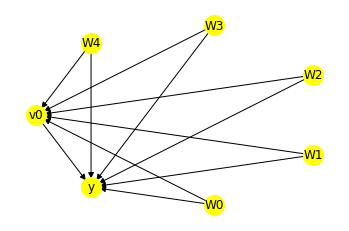

In [62]:
# visualize graph
model.view_model(layout='dot')
# from IPython.display import display, Image
# display(Image(filename="causal_model.png"))

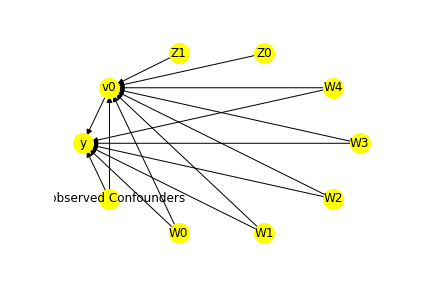

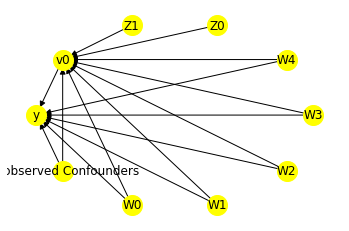

In [63]:
# I. Create a causal model from the data and given graph.
model = CausalModel(
    data=data["df"],
    treatment=data["treatment_name"][0],
    outcome=data["outcome_name"][0],
    graph=data["gml_graph"])
model.view_model(layout="dot")

from IPython.display import display, Image
display(Image(filename="causal_model.png"))

In [64]:
# Ⅱ. Identify causal effect and return target estimands
identified_estimand = model.identify_effect(proceed_when_unidentifiable=True)
print(identified_estimand)

Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                                 
─────(Expectation(y|W2,W1,W0,W3,W4))
d[v₀]                               
Estimand assumption 1, Unconfoundedness: If U→{v0} and U→y then P(y|v0,W2,W1,W0,W3,W4,U) = P(y|v0,W2,W1,W0,W3,W4)

### Estimand : 2
Estimand name: iv
Estimand expression:
Expectation(Derivative(y, [Z1, Z0])*Derivative([v0], [Z1, Z0])**(-1))
Estimand assumption 1, As-if-random: If U→→y then ¬(U →→{Z1,Z0})
Estimand assumption 2, Exclusion: If we remove {Z1,Z0}→{v0}, then ¬({Z1,Z0}→y)

### Estimand : 3
Estimand name: frontdoor
No such variable found!



In [65]:
# Ⅲ. Estimate the target estimand using a statistical method

property_estimate = model.estimate_effect(
    identified_estimand,
    method_name="backdoor.dowhy.propensity_score_stratification",
    
)

print(property_estimate)

*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                                 
─────(Expectation(y|W2,W1,W0,W3,W4))
d[v₀]                               
Estimand assumption 1, Unconfoundedness: If U→{v0} and U→y then P(y|v0,W2,W1,W0,W3,W4,U) = P(y|v0,W2,W1,W0,W3,W4)

## Realized estimand
b: y~v0+W2+W1+W0+W3+W4
Target units: ate

## Estimate
Mean value: 10.060571298328696



/Users/ryoto/opt/anaconda3/envs/ml/lib/python3.7/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/Users/ryoto/opt/anaconda3/envs/ml/lib/python3.7/site-packages/dowhy/causal_estimators/propensity_score_stratification_estimator.py:61: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  weighted_outcomes.columns = ["_".join(x) for x in weighted_outcomes.columns.ravel()]


In [66]:
# IV. Refute the obtained estimate using multiple robustness checks.
refute_results = model.refute_estimate(identified_estimand, property_estimate,
                                       method_name="placebo_treatment_refuter")
print(refute_results)

/Users/ryoto/opt/anaconda3/envs/ml/lib/python3.7/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/Users/ryoto/opt/anaconda3/envs/ml/lib/python3.7/site-packages/dowhy/causal_estimators/propensity_score_stratification_estimator.py:61: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  weighted_outcomes.columns = ["_".join(x) for x in weighted_outcomes.columns.ravel()]
/Users/ryoto/opt/anaconda3/envs/ml/lib/python3.7/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/Users/ryoto/opt/anaconda3/envs/ml/lib/python3.7/site-packages/dowhy/causal_estimators/propensity_score_st

Refute: Use a Placebo Treatment
Estimated effect:10.060571298328696
New effect:0.0037972711910103075
p value:0.44



/Users/ryoto/opt/anaconda3/envs/ml/lib/python3.7/site-packages/dowhy/causal_estimators/propensity_score_stratification_estimator.py:61: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  weighted_outcomes.columns = ["_".join(x) for x in weighted_outcomes.columns.ravel()]
/Users/ryoto/opt/anaconda3/envs/ml/lib/python3.7/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/Users/ryoto/opt/anaconda3/envs/ml/lib/python3.7/site-packages/dowhy/causal_estimators/propensity_score_stratification_estimator.py:61: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  weighted_outcomes.columns = ["_".join(x) for x in weighted_outcomes.columns.ravel()]
